In [1]:
import os
import pickle

import sklearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pylab import plot, show, title, xlabel, ylabel, subplot
from scipy import fft, fftpack, arange
from scipy.signal import butter, lfilter, freqz

from sklearn import cross_validation
from sklearn import svm, decomposition
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.decomposition import RandomizedPCA, PCA, FastICA
from sklearn.svm import SVC
from sklearn import manifold

# That's an impressive list of imports.
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We import sklearn.

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
from sklearn.utils.extmath import _ravel

# We'll use matplotlib for graphics.
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    txts = []
    for i in range(4):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

###################################################################
###################### Define Useful Functions ####################

def butter_bandpass(lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandstop(lowstop, highstop, fs, order=2):
    nyq = 0.5 * fs
    low = lowstop / nyq
    high = highstop / nyq
    b, a = butter(order, [low, high], btype='bandstop')
    return b, a

# Linear filter application
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_bandstop_filter(data, lowstop, highstop, fs, order=2):
    b, a = butter_bandstop(lowstop, highstop, fs, order=order)
    y = lfilter(b, a, data)
    return y

def filter_eeg(data, fs, bandstop=[50, 60], bandpass=[5, 30], order=4):
    if bandstop:
        lowstop, highstop = bandstop
        data = butter_bandstop_filter(data, lowstop, highstop, fs, order)
    if bandpass:
        lowpass, highpass = bandpass
        data = butter_bandpass_filter(data, lowpass, highpass, fs, order)
    return data


def normalize(dataframe):
    #feature matrix normalization
    dataframe = ((dataframe - dataframe.mean()) / (dataframe.max() - dataframe.min())) + 1
    return dataframe

def normalize_column(column):
    #feature vector normalization
    column = ((column - column.mean()) / (column.max() - column.min())) + 1
    return column

def apply_pca(data, n_components=3, whiten='true'):
    pca = PCA(n_components=n_components, whiten=whiten)
    data = pca.fit_transform(data)
    return data

def apply_randomized_pca(data, n_components=3, whiten='true'):
    pca = RandomizedPCA(n_components=n_components, whiten=whiten)
    data = pca.fit_transform(data)
    return data

def apply_ica(data, n_components=3):
    ica = FastICA(n_components=n_components)
    data = ica.fit_transform(data)  # Reconstruct signals
#     mixin = ica.mixing_
    return data

###################################################################
######################## Define Some Constants ####################

#Emotiv Epoc sampling rate
fs = 128

class_label_map = {
                    0 : 'Left',
                    1 : 'Up',
                    2 : 'Right',
                    3 : 'Down',
}

param_grid = {'C': [1e-2, 3e-2, 1e-1, 3e-1, 5e-1, 1e0, 5e0, 1e1, 5e1, 1e2, 5e2, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [5e-5, 0.0005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],}

In [2]:
# List files in log folder
file_names = os.listdir('logs/')[1:]
[i for i in enumerate(file_names)]

[(0, '2016-08-01--18-36-test.csv'),
 (1, '2016-08-01--21-59_mike_motor_armwaving.csv'),
 (2, '2016-08-01--23-27_andres_motor.csv'),
 (3, '2016-08-01--23-39_andres_motor_foot.csv'),
 (4, '2016-08-03--21-55_andres_ssvep_first.csv'),
 (5, '2016-08-03--22-21_mike_ssvep_first.csv'),
 (6, '2016-08-04--00-01_mike_ssvep_second.csv'),
 (7, '2016-08-04--00-03_mike_ssvep_second.csv'),
 (8, '2016-08-04--17-58_newconcat_ssvep_concat.csv'),
 (9, '2016-08-04--20-03_mike_ssvep_SSVEP_C#.csv'),
 (10, '2016-08-04--20-08_mike_ssvep_SSVEP_C#_2.csv'),
 (11, '2016-08-04--20-18_mike_ssvep_SSVEP_C#_3.csv'),
 (12, 'andres_test (2).csv'),
 (13, 'andres_test_redo.csv'),
 (14, 'mike_redo.csv'),
 (15, 'mike_test.csv'),
 (16, 'output.csv')]

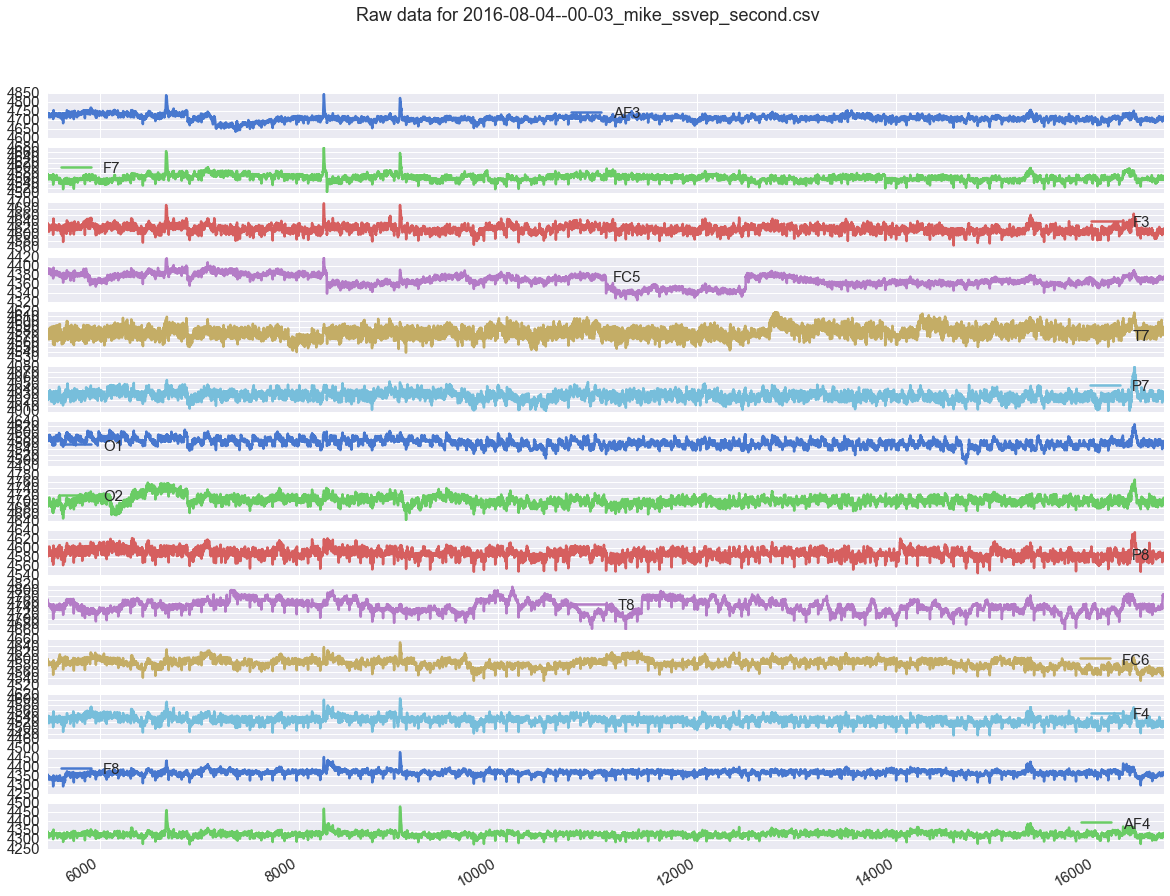

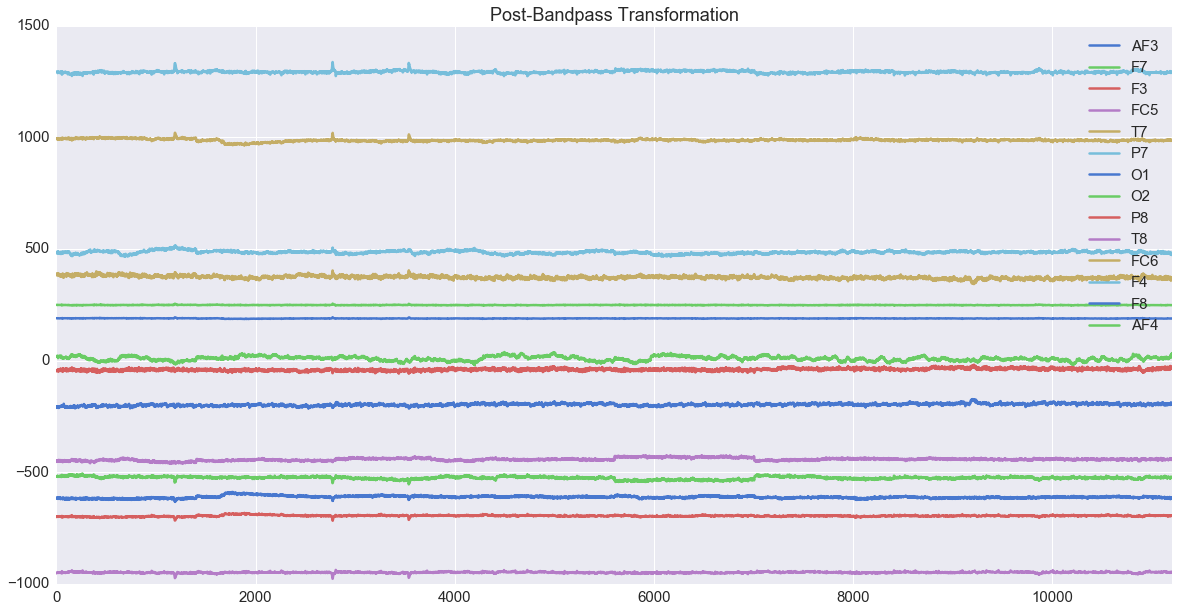

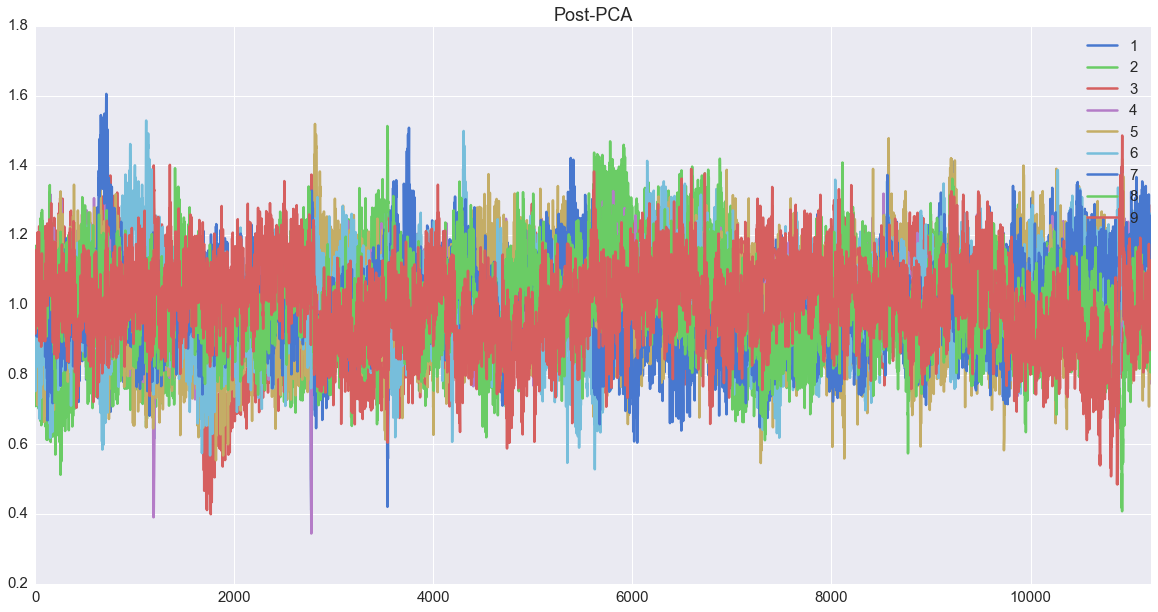

In [3]:
### read output csv from eeg-session
master = pd.read_csv('./logs/' + file_names[7],
                     usecols=['AF3','AF4','F3','F4','F7','F8','FC5','FC6','O1','O2','P7','P8','T7','T8', 'CLASS']
)

#filter bad regions, if any
master = master[5476:]
df = master.ix[:, :-1]

#Plot each electrode's response
df.plot(figsize=(20, 15), title='Raw data for '+ file_names[7], subplots=True)

#apply butterworth filter
df = pd.DataFrame(filter_eeg(df.ix[:, :14], fs, bandstop=[50, 60], bandpass=[20, 50]), columns=master.columns[:-1])
df.plot(figsize=(20, 10), title='Post-Bandpass Transformation')


# filtered_data = pd.DataFrame(apply_ica(df, n_components=13))
# filtered_data = filtered_data.ix[:, 1:10]
# filtered_data = filtered_data.apply(normalize_column)
# filtered_data.plot(title='Post-ICA', figsize=(20, 10))

filtered_data = pd.DataFrame(apply_pca(df, n_components=13, whiten=False))
#remove first and last four component
filtered_data = filtered_data.ix[:, 1:9]
filtered_data = filtered_data.apply(normalize_column)
filtered_data.plot(title='Post-PCA', figsize=(20, 10))

# filtered_data = pd.DataFrame(apply_randomized_pca(df, n_components=13, whiten=False))
# filtered_data = filtered_data.ix[:, 1:9]
# filtered_data = filtered_data.apply(normalize_column)
# filtered_data.plot(title='Post-Randomized PCA', figsize=(20, 10))

Class balance:  [array([ 0.,  1.,  2.,  3.]), array([95, 87, 87, 87])] 

Number of training examples:  356 

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 

             precision    recall  f1-score   support

       Left       0.95      0.81      0.88        26
         Up       0.73      0.80      0.76        10
       Down       0.79      0.83      0.81        18
      Right       0.80      0.89      0.84        18

avg / total       0.84      0.83      0.84        72



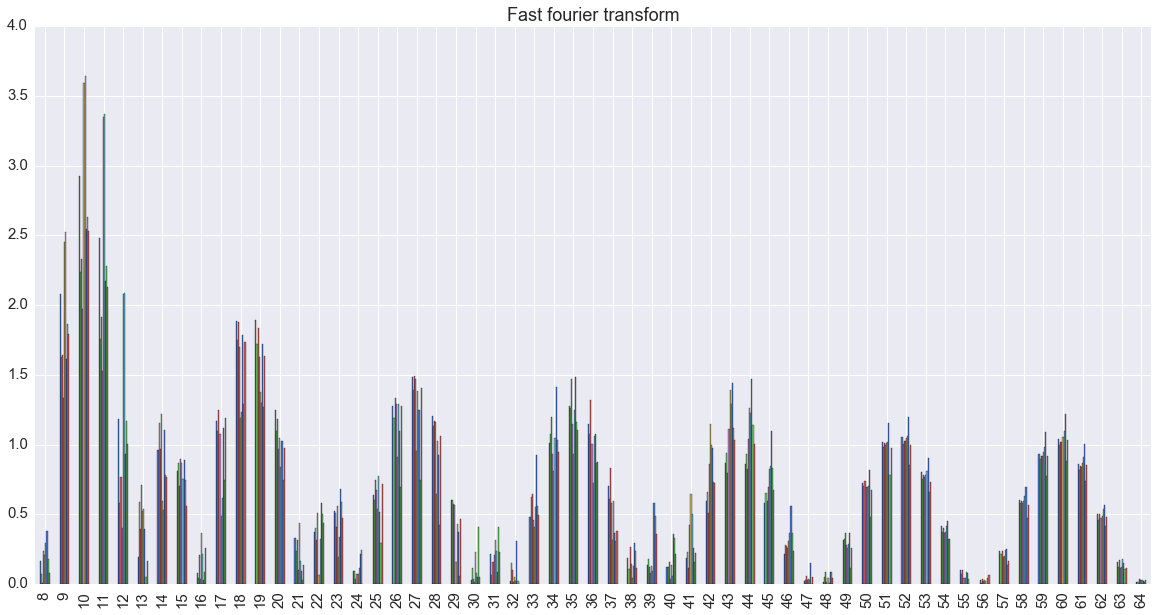

In [4]:
filtered_data['CLASS'] = master['CLASS']
X, Y = [], []

sample_size = 16
dc_cutoff = int(fs/sample_size)

# #Group csv by class, apply fourier to 1 second intervals, combine
for class_label, timeseries in filtered_data.groupby('CLASS'):
    timeseries = timeseries.ix[:,:-1]
    for second in range(int(len(timeseries) / sample_size)):
        start, end = ((second) * sample_size, (second + 1) * sample_size)
        timeseries_ = timeseries[start:end]
        
        #apply real-fastt-fourier, remove DC-term
        ft = abs(np.fft.rfft(timeseries_, n=128, axis=0, norm=None).real)[dc_cutoff:]
        X.append(ft.ravel())
        Y.append(class_label)

X = np.array(X)
Y = np.array(Y)

print ('Class balance: ', list(np.unique(Y, return_counts=True)), '\n')
print ('Number of training examples: ', len(X), '\n')

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size=0.20, random_state=42)
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, n_jobs=-1)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(clf.best_estimator_, '\n')
target_names=['Left', 'Up', 'Down', 'Right']
print(classification_report(y_test, y_pred, target_names=target_names))
s = pickle.dumps(clf)

#plot the last one
ft = pd.DataFrame(ft)
ft.index = [i for i in range(dc_cutoff, len(ft) + dc_cutoff)]
ft.plot(kind='bar', legend=None, title='Fast fourier transform', figsize=(20, 10))

In [7]:
#Apply four-fold cross-validation
kf = cross_validation.KFold(len(X), n_folds=4, random_state=42, shuffle=True)
for train_index, test_index in kf:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    

    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, n_jobs=-1)
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.best_estimator_, '\n')
    target_names=['Left', 'Up', 'Down', 'Right']
    print(classification_report(y_test, y_pred, target_names=target_names))   


SVC(C=0.5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 

             precision    recall  f1-score   support

       Left       0.86      0.80      0.83        30
         Up       0.64      0.47      0.54        15
       Down       0.75      0.71      0.73        21
      Right       0.73      0.96      0.83        23

avg / total       0.76      0.76      0.76        89

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 

             precision    recall  f1-score   support

       Left       0.74      0.81      0.77        21
         Up       0.69      0.60      0.64        30
       Down       0.50      0.60      0.55        20
      Ri

Computing t-SNE embedding


(<matplotlib.figure.Figure at 0x1041db4a8>,
  <matplotlib.text.Text at 0x11dad8588>])

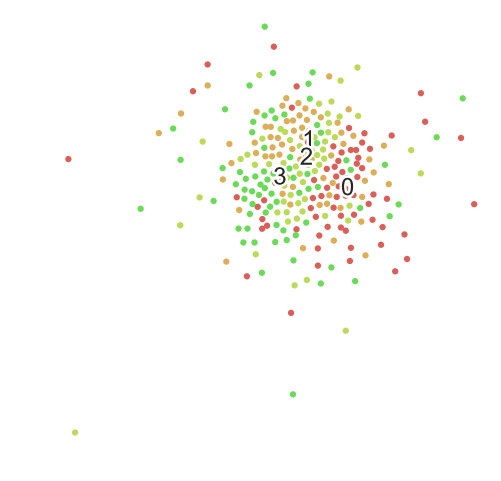

In [6]:
# t-SNE embedding
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=42)
X_tsne = tsne.fit_transform(X_train)
scatter(X_tsne, y_train)